In [1]:

import matplotlib.pyplot as plt
import numpy as np
import snntorch as snn
import snntorch.functional as SF
from snntorch import spikeplot as splt
import snntorch.spikegen as spikegen
import torch
from torch import nn
from torch.optim import Adam


In [11]:

class MultimodalIntegration(nn.Module):
	"""
	Combine the outputs from the visual and auditory encoders into a single multimodal representation.
	"""

	def __init__(self, input_size, hidden_size, output_size, beta):
		super(MultimodalIntegration, self).__init__()

		self.flatten = nn.Flatten()
		self.fc1 = nn.Linear(input_size, hidden_size)
		self.lif1 = snn.Leaky(beta=beta)
		self.fc2 = nn.Linear(hidden_size, hidden_size)
		self.lif2 = snn.Leaky(beta=beta)
		self.fc3 = nn.Linear(hidden_size, output_size)
		self.lif3 = snn.Leaky(beta=beta)

	def forward(self, x):
		x = self.flatten(x.to(torch.float32))
		#print(f"Shape after flattening: {x.shape}")
		mem1 = self.lif1.init_leaky()
		mem2 = self.lif2.init_leaky()
		mem3 = self.lif3.init_leaky()
		cur1 = self.fc1(x)
		spk1, mem1 = self.lif1(cur1, mem1)
		cur2 = self.fc2(spk1)
		spk2, mem2 = self.lif2(cur2, mem2)
		cur3 = self.fc3(spk2)
		spk3, mem3 = self.lif3(cur3, mem3)
		return spk3, mem3

In [19]:

# ## Hyperparameters
beta = 0.9  # Decay rate of the LIF neuron
hidden_size = 128  # Size of the hidden layer
output_size = 10  # Output size for the final multimodal representation
input_size = 40  # Correct input size based on concatenation of visual and auditory spikes

# Load the visual outputs file
sensory_data = np.load('paired_input_noise_0p0.npy')
all_labels = np.load('all_labels.npy')
labels = all_labels[0,:].copy()

In [20]:
sensory_data.shape

(2560, 40, 81)

In [21]:
# Concatenate the encoded spikes
combined_spikes = torch.from_numpy(sensory_data)

net = MultimodalIntegration(input_size, hidden_size, output_size, beta)


In [22]:

loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(net.parameters(), lr=0.01)

targets = torch.from_numpy(labels)

In [28]:
# Training loop
num_epochs = 10
# num_samples = min(vis_spikes.shape[0], aud_spikes.shape[0], targets.shape[0])  # Use the minimum size across datasets 512
#num_samples = 3000

num_steps = 81  # Number of timesteps for the spike train

for epoch in range(num_epochs):
	epoch_loss = 0.0

	for i in range(np.size(sensory_data, 0)):

		target = targets[i].unsqueeze(0)

		# Initialize hidden states
		mem1 = net.lif1.init_leaky()
		mem2 = net.lif2.init_leaky()
		mem3 = net.lif3.init_leaky()

		# Accumulate loss over timesteps
		total_loss = 0.0
		optimizer.zero_grad()

		for t in range(num_steps):
			# Flatten the spike train for the current timestep
			input_t = combined_spikes[i,:,t].unsqueeze(0)

			# Forward pass through the network for each timestep
			spk3, mem3 = net(input_t)

			# Compute loss for this timestep
			loss = loss_fn(spk3, target.long())
			total_loss += loss

		# Backward pass and optimization
		total_loss.backward()
		optimizer.step()

		epoch_loss += total_loss.item()

	avg_loss = epoch_loss / np.size(sensory_data, 0)
	print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}')

print("Training complete")


torch.Size([1, 81, 20])


torch.Size([1, 81, 20])
torch.Size([81, 40])
Vision Input: shape=torch.Size([1, 81, 20]), spikes=947.0
Audio: shape=torch.Size([1, 81, 20]), spikes=441.0
Output: shape=torch.Size([81, 1, 10]), spikes=243.0
Memvrane potential: shape=torch.Size([81, 1, 10]), Max potential=np.maxtensor([[[  88.8260,   69.0028,   30.4634, -591.4258, -584.0934, -584.2539,
          -584.4554, -536.0817, -585.1283, -577.5996]],

        [[  88.8260,   69.0028,   30.4634, -591.4258, -584.0934, -584.2539,
          -584.4554, -536.0817, -585.1283, -577.5996]],

        [[  88.8260,   69.0028,   30.4634, -591.4258, -584.0934, -584.2539,
          -584.4554, -536.0817, -585.1283, -577.5996]],

        [[  88.8260,   69.0028,   30.4634, -591.4258, -584.0934, -584.2539,
          -584.4554, -536.0817, -585.1283, -577.5996]],

        [[  88.8260,   69.0028,   30.4634, -591.4258, -584.0934, -584.2539,
          -584.4554, -536.0817, -585.1283, -577.5996]],

        [[  88.8260,   69.0028, 

TypeError: Axes.scatter() got multiple values for argument 's'

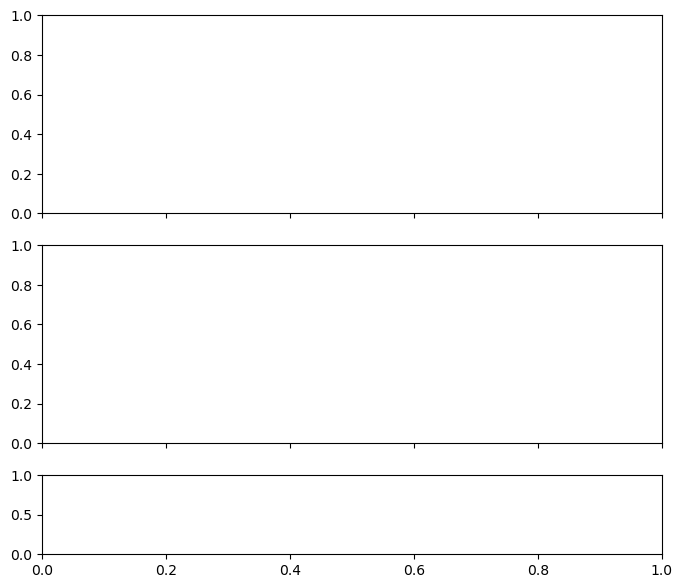

In [10]:

def do_and_plot_model_inference(visual_spikes, audio_spikes, targets, ex=0):
#	visual_spk = visual_spikes[ex, :, :]
	visual_spk = spikegen.rate(visual_spikes[ex, :, :], num_steps=1) #converts to a poisson distribution
	audio_spk = spikegen.rate(audio_spikes[ex, :, :], num_steps=1)
	print(np.shape(visual_spk))
	print("\n")
	print(np.shape(audio_spk))
	#breakpoint
	target = targets[ex].unsqueeze(0)

	# Concatenate the encoded spikes
	combined_spikes_rate  = torch.cat((visual_spk, audio_spk), dim=2)
	combined_spikes_rate  = combined_spikes_rate  .reshape(81,40)
	print(np.shape(combined_spikes_rate)) #it should be 91x20
	# Forward pass through the integration layer
	outputs = []
	memV = []

	mem3 = net.lif3.init_leaky()
	num_time_points = 81 # np.shape(visual_spk[0]).astype(int)
	for t in range(num_time_points):
		input_t_rate = combined_spikes_rate[t].view(1, -1)
		output, mem3 = net(input_t_rate)
		outputs.append(output)
		memV.append(mem3)
		#outputs.append(mem3)
	outputs = torch.stack(outputs)
	memV = torch.stack(memV)

	

	print(f"Vision Input: shape={visual_spk.shape}, spikes={visual_spk.sum()}")
	print(f"Audio: shape={audio_spk.shape}, spikes={audio_spk.sum()}")
	print(f"Output: shape={outputs.shape}, spikes={outputs.sum()}")

	print(f"Memvrane potential: shape={memV.shape}, Max potential=np.max{(memV)}")
	print(f"Ground truth: {target}")




	fig, ax = plt.subplots(3, figsize=(8, 7), sharex=True,
						   gridspec_kw={'height_ratios': [1, 1, 0.4]})

	# Plot hidden layer spikes
	#splt.raster(visual_spk, ax[0], s=5, c="black")
	splt.raster(visual_spk, ax[0], s=5, c="black", marker="|")

	ax[0].set_ylabel("Vision Hidden")

	# Plot hidden layer spikes
	splt.raster(audio_spk, ax[1], s=5, c="black")
	ax[1].set_ylabel("Audio Hidden")

	# Plot output spikes
	splt.raster(outputs.reshape(num_steps, -1), ax[2], c="black", marker="|")
	ax[2].set_ylabel("Output")

	ax[0].set_ylim((-2.45, 51.45))
	ax[1].set_ylim((-2.45, 51.45))
	ax[2].set_ylim([0, 9])

	plt.tight_layout()
	plt.show()

# %% [markdown]
# ### Visual and audio the same

do_and_plot_model_inference(vis_spikes, aud_spikes, targets, ex=1)

# %% [markdown]
# ### Vision good but audio random


In [12]:

do_and_plot_model_inference(vis_spikes, aud_spikes, targets, ex=1)

# %% [markdown]
# # Questions and todo
# 
# * include audio hidden output
# * how to convert multimodal output spike train into final answer


torch.Size([1, 81, 20])


torch.Size([1, 81, 20])
torch.Size([81, 40])
Vision Input: shape=torch.Size([1, 81, 20]), spikes=947.0
Audio: shape=torch.Size([1, 81, 20]), spikes=441.0
Output: shape=torch.Size([81, 1, 10]), spikes=243.0
Memvrane potential: shape=torch.Size([81, 1, 10]), Max potential=np.maxtensor([[[  63.9802,   79.0848,   33.2360, -465.8821, -458.8828, -457.5385,
          -412.2772, -475.3934, -444.2844, -471.9661]],

        [[  63.9802,   79.0848,   33.2360, -465.8821, -458.8828, -457.5385,
          -412.2772, -475.3934, -444.2844, -471.9661]],

        [[  63.9802,   79.0848,   33.2360, -465.8821, -458.8828, -457.5385,
          -412.2772, -475.3934, -444.2844, -471.9661]],

        [[  63.9802,   79.0848,   33.2360, -465.8821, -458.8828, -457.5385,
          -412.2772, -475.3934, -444.2844, -471.9661]],

        [[  63.9802,   79.0848,   33.2360, -465.8821, -458.8828, -457.5385,
          -412.2772, -475.3934, -444.2844, -471.9661]],

        [[  63.9802,   79.0848, 